(binary_hgf)=
# The binary Hierarchical Gaussian Filter

In [1]:
import jax.numpy as jnp
from ghgf.model import HGF
from ghgf import load_data
import seaborn as sns

## Imports
Import binary responses from {cite:p}`2013:iglesias`.

In [2]:
timeserie = load_data("binary")

# Format the data input accordingly (a value column and a time column)
data = jnp.array([timeserie, jnp.arange(1, len(timeserie) + 1, dtype=float)]).T

## Using a two-levels model
### Create the model

In [3]:
two_levels_hgf = HGF(
    n_levels=2,
    model_type="binary",
    initial_mu={"1": .0, "2": .5},
    initial_pi={"1": .0, "2": 1e4},
    omega={"1": None, "2": -6.0},
    rho={"1": None, "2": 0.0},
    kappas={"1": None},
    eta0=0.0,
    eta1=1.0,
    pihat = jnp.inf,
)

Creating a binary Hierarchical Gaussian Filter with 2 levels (JAX backend).


### Add data

In [4]:
# Provide new observations
two_levels_hgf = two_levels_hgf.input_data(data)

Add 320 new binary observations.


### Plot trajectories

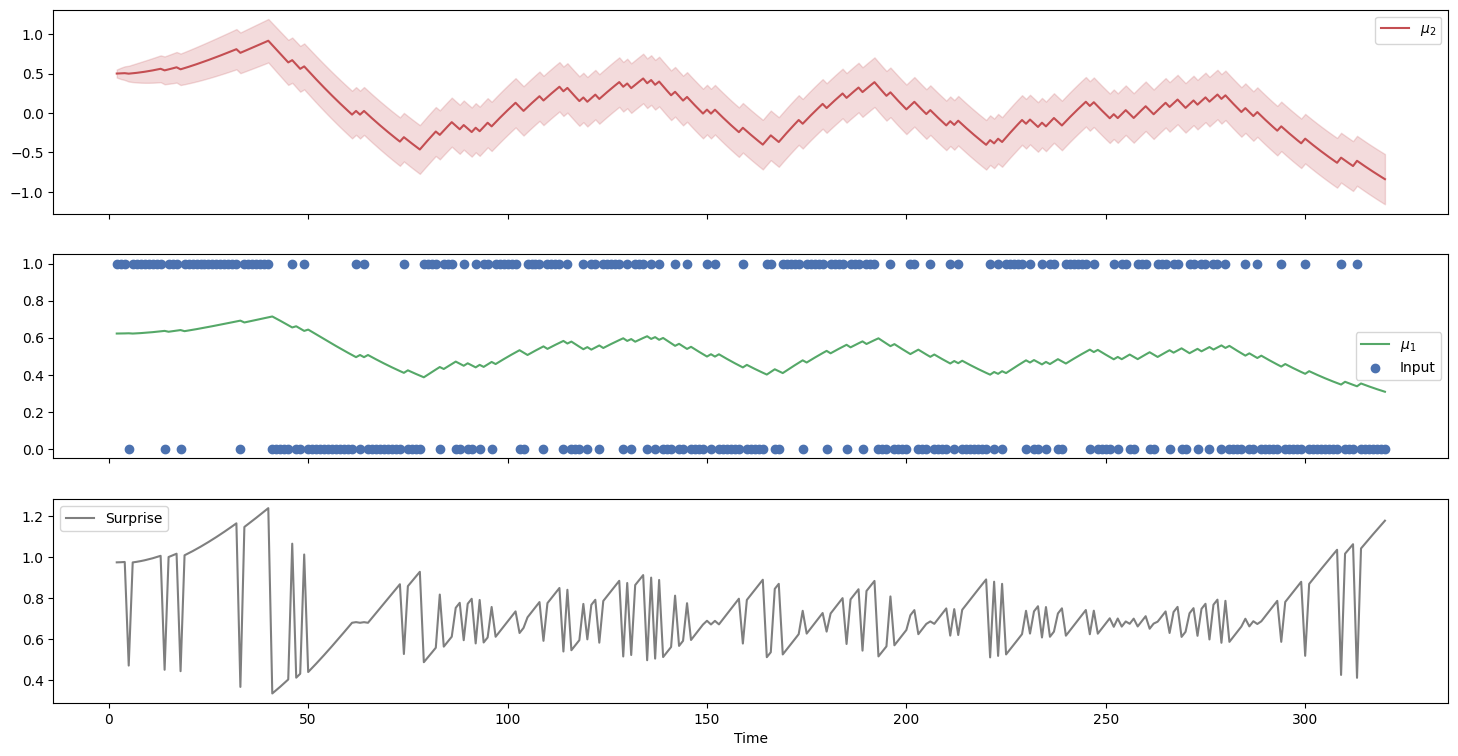

In [5]:
two_levels_hgf.plot_trajectories()

## Using a three-level model
### Create the model

In [6]:
three_levels_hgf = HGF(
    n_levels=3,
    model_type="binary",
    initial_mu={"1": .0, "2": .5, "3": 0.},
    initial_pi={"1": .0, "2": 1e4, "3": 1e1},
    omega={"1": None, "2": -6.0, "3": -2.0},
    rho={"1": None, "2": 0.0, "3": 0.0},
    kappas={"1": None, "2": 1.0},
    eta0=0.0,
    eta1=1.0,
    pihat = jnp.inf,
)

Creating a binary Hierarchical Gaussian Filter with 3 levels (JAX backend).


### Add data

In [7]:
three_levels_hgf = three_levels_hgf.input_data(data)

Add 320 new binary observations.


### Plot trajectories

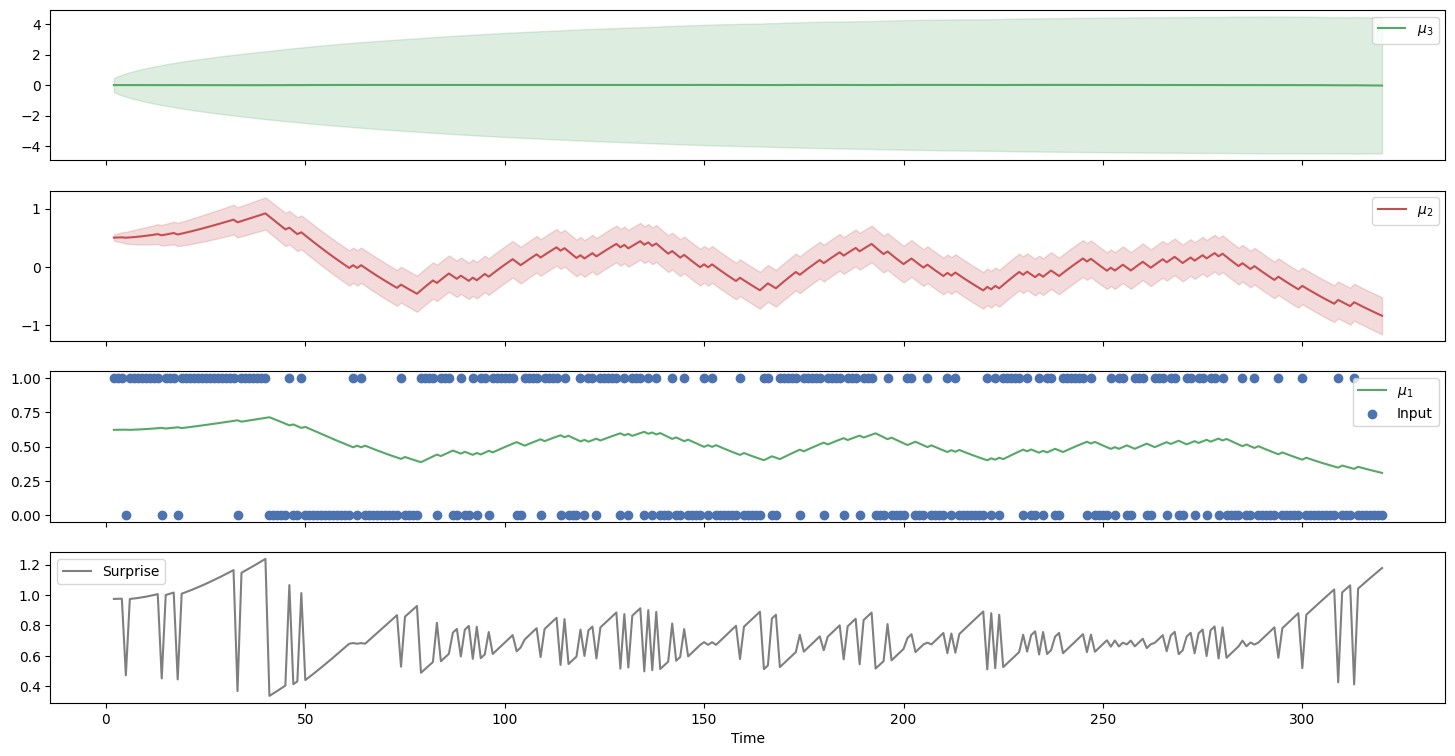

In [8]:
three_levels_hgf.plot_trajectories()